In [1]:
import shap
import pickle
import numpy as np
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       ensure_shap_values_are_3d
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
shap.initjs()
%matplotlib inline
task_name = '08'

In [2]:
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)
with open(task_name + '.expl', 'rb') as f:
    explanations, _, _ = pickle.load(f)

# Local Explanations

Here we will use the explanations obtained globally for the multiclass difference classifier to cluster instances, and inspect the individual classifiers explanations on a local level.

In [4]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff_proba = comparer.predict_mclass_diff_proba(explanations.data)

## Cluster Explanations in an Unsupervised Manner

We will cluster instances, for which the two classifiers have different predictions, with a hierarchical clustering algorithm using squared euclidian distances.

In [15]:
explanations_diff = explanations[is_pred_diff]
shap_values = explanations_diff.mclass_diff.log_odds[:, :, comparer.difference_class_names]
shap_values = ensure_shap_values_are_3d(shap_values)
values = shap_values.values.reshape(
    (shap_values.values.shape[0],
     shap_values.values.shape[1] * shap_values.values.shape[2]))
values = np.concatenate([values], axis=1)
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

In the dendrogram we see, that there are basically two equally sized clusters that can be investigated further.

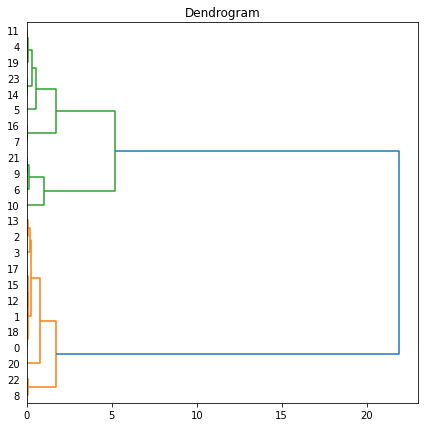

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax)
ax.set_title('Dendrogram')
plt.show()

In [52]:
n_clusters = 2
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust')
clustering -= 1

In the decision boundary plot we see, that the instances from the two difference classes are assigned to the two clusters.

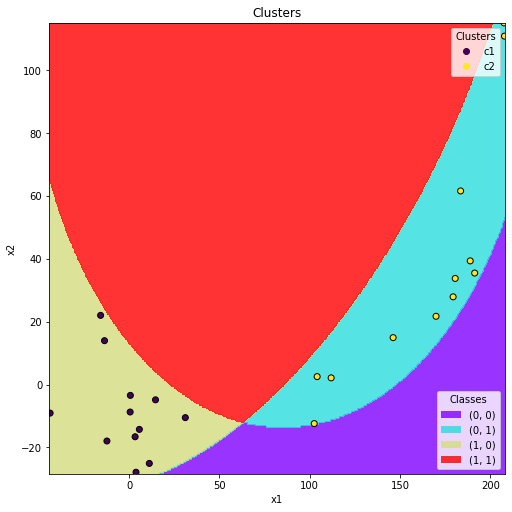

In [55]:
idx_x, idx_y = 0, 1
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
x_min, x_max = explanations_diff.data[:, idx_x].min() - .5, explanations_diff.data[:, idx_x].max() + .5
y_min, y_max = explanations_diff.data[:, idx_y].min() - .5, explanations_diff.data[:, idx_y].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
z_pred = comparer.predict_mclass_diff(np.c_[xx.ravel(), yy.ravel()])
z_pred = z_pred.reshape(xx.shape)
plt_colors = cm.rainbow(np.linspace(0, 1, len(comparer.classes)))
levels = np.arange(len(comparer.classes)+1)
contour = ax.contourf(xx, yy, z_pred + 0.5, levels, colors=plt_colors, alpha=.8)
scatter = ax.scatter(explanations_diff.data[:, idx_x], explanations_diff.data[:, idx_y], c=clustering, edgecolors='k')
ax.set_xlabel(comparer.feature_names[idx_x])
ax.set_ylabel(comparer.feature_names[idx_y])
ax.set_title('Clusters')
cluster_legend = plt.legend(scatter.legend_elements()[0], cluster_names, title='Clusters', loc='upper right')
plt.gca().add_artist(cluster_legend)
plt.legend(contour.legend_elements()[0], comparer.class_names, title='Classes', loc='lower right');

In [58]:
explanations_clustered = explanations_diff.cohorts(cluster_names[clustering])

We can further analyze the value ranges present in each cluster:

In [94]:
columns = ['x1.min', 'x1.mean', 'x1.max', 'x2.min', 'x2.mean', 'x2.max']
make_row = lambda df: pd.Series([
        df['x1'].min(),
        df['x1'].mean(),
        df['x1'].max(),
        df['x2'].min(),
        df['x2'].mean(),
        df['x2'].max(),
    ], index=columns)
statistics = pd.DataFrame(columns=columns)
statistics.loc['all'] = make_row(pd.DataFrame(explanations.data, columns=comparer.feature_names))
for cluster_name, X in explanations_clustered.data.cohorts.items():
    df = pd.DataFrame(X, columns=comparer.feature_names)
    statistics.loc[cluster_name, :] = make_row(df)
statistics

,x1.min,x1.mean,x1.max,x2.min,x2.mean,x2.max
all,-181.190181,84.138769,307.157526,-374.445022,9.979408,258.940851
c1,-43.736132,-1.189974,31.135043,-27.904182,-8.549452,22.006794
c2,102.516707,164.501251,207.880114,-12.429834,37.735578,115.062427


### Feature Influence

Obtain a feature order, ranked by mean absolute influence on the instances with different predictions:

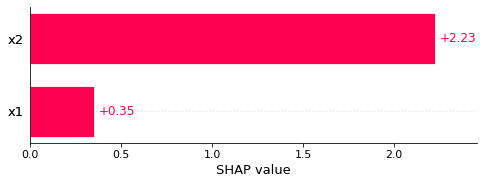

In [59]:
feature_order, feature_importance = calc_feature_order(explanations.bin_diff.log_odds[is_pred_diff])
plot_feature_importance_bar(feature_importance)

We see, that x2 is the main influence for the predictions being classified as different, but x1 influences most, what cluster and difference class is classified.

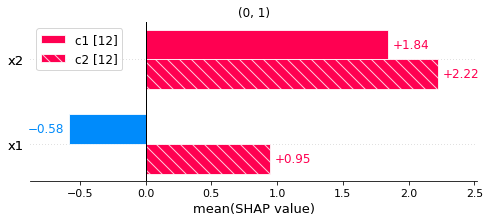

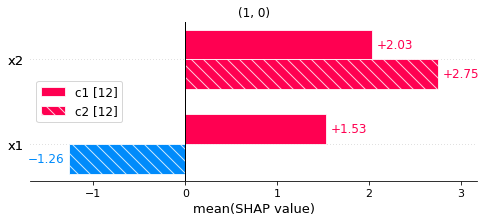

In [60]:
for label in comparer.difference_class_names:
    plt.title(label)
    shap.plots.bar(explanations_clustered.mclass_diff.log_odds[:, :, label].mean(0))

### Feature Effects

Looking at the marginal effects of the two features on the outcome we can confirm, that the differences of the effects of x1 are bigger than those of x2 and that it is of a different shape for each cluster.

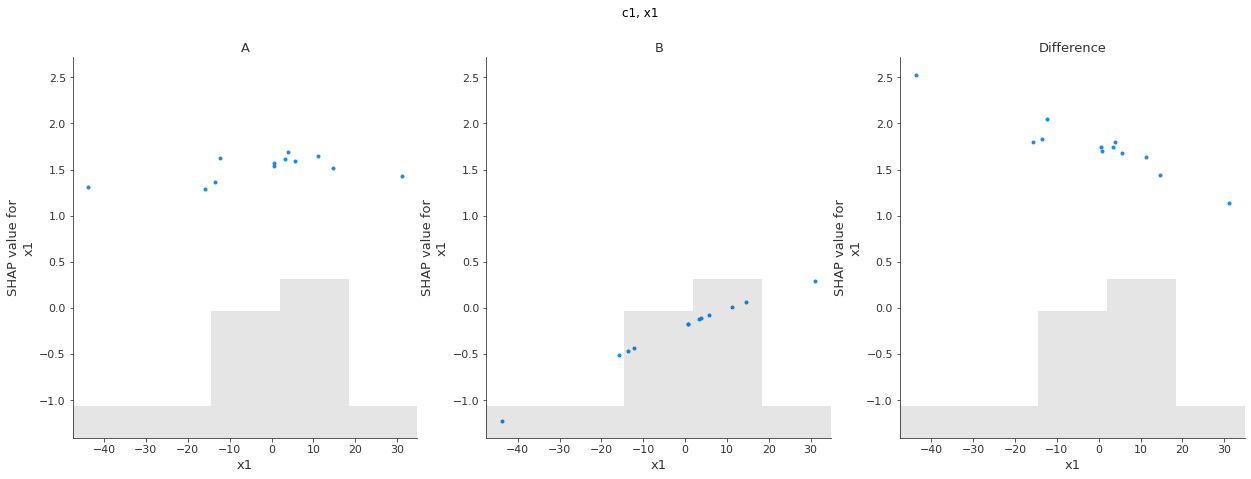

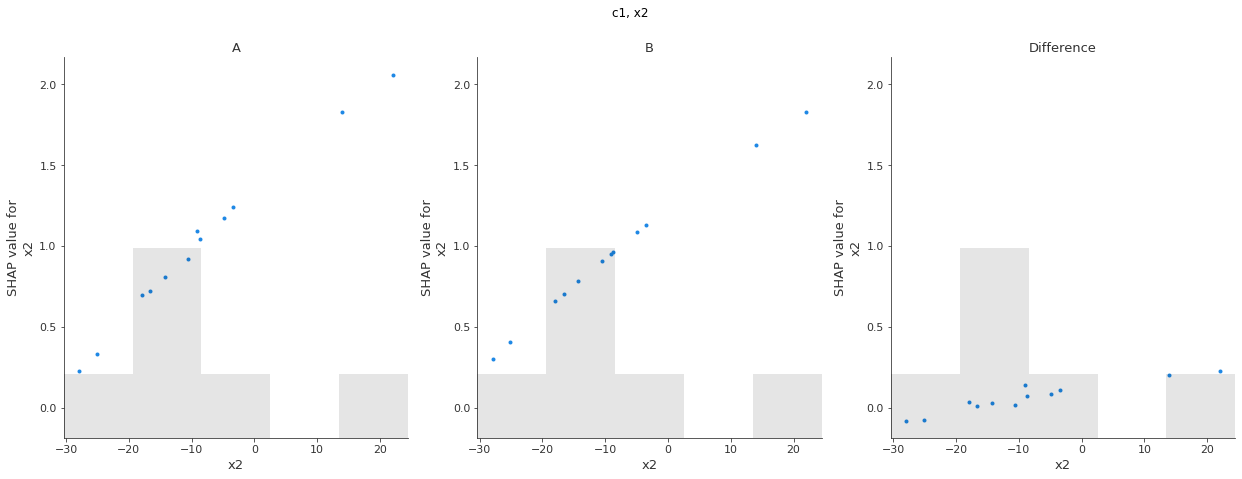

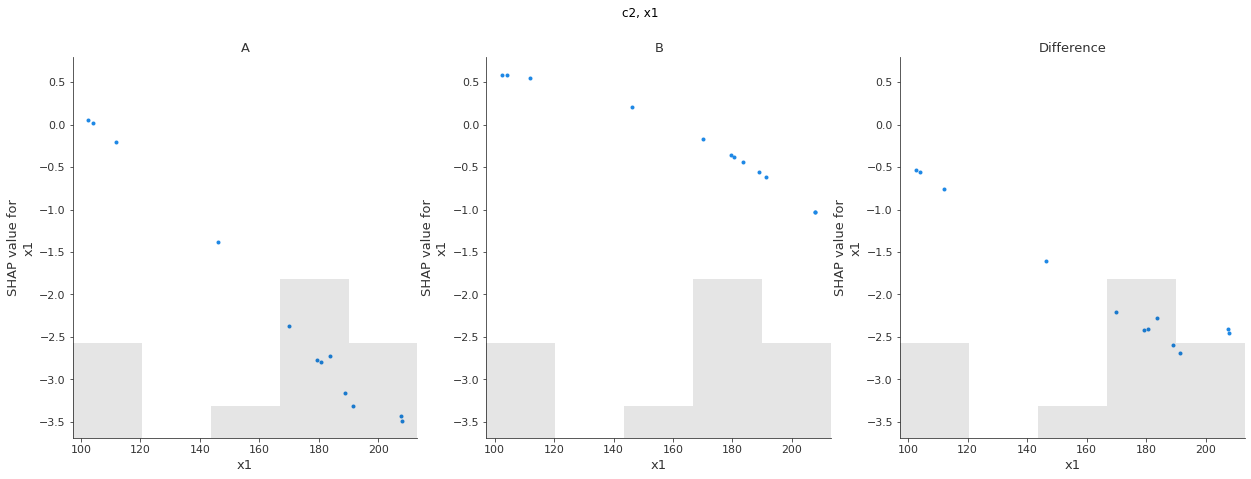

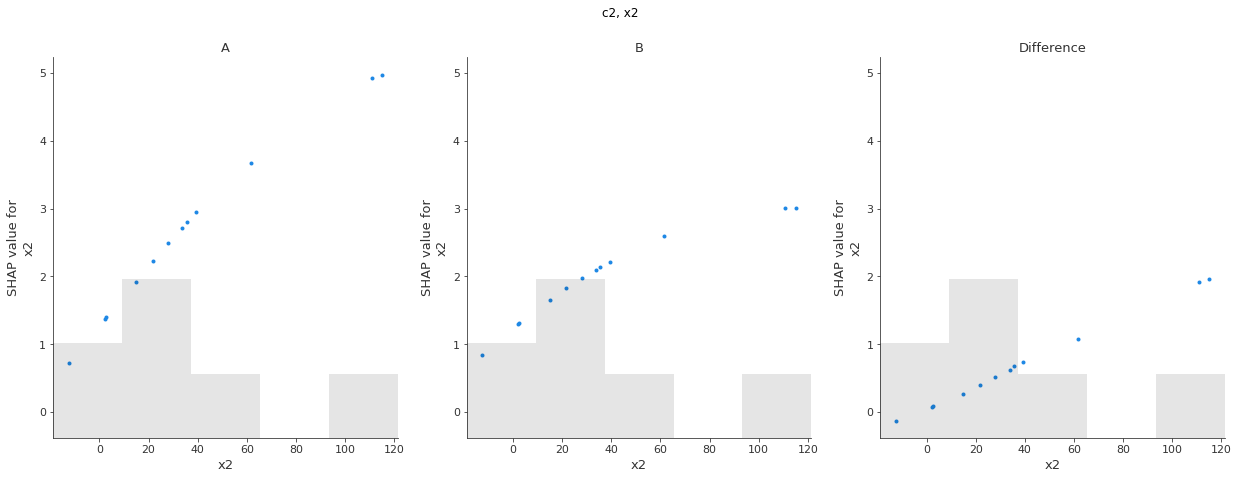

In [63]:
indiv = explanations_clustered.indiv.log_odds[:, :, 1]
diff = explanations_clustered.indiv_diff.log_odds[:, :, 1]
for (cluster_name, shap_values_a), shap_values_b, shap_values_diff in \
    zip(indiv.A.cohorts.items(), indiv.B.cohorts.values(), diff.cohorts.values()):
        for feature in comparer.feature_names:
            fig, axs = plt.subplots(ncols=3, figsize=(21, 7), sharex=True, sharey=True)
            shap.plots.scatter(shap_values_a[:, feature], ax=axs[0], title='A', show=False)
            shap.plots.scatter(shap_values_b[:, feature], ax=axs[1], title='B', show=False)
            shap.plots.scatter(shap_values_diff[:, feature], ax=axs[2], title='Difference', show=False)
            fig.suptitle(f'{cluster_name}, {feature}')
            plt.show()

### Decision Plot

We see quite different decision paths for the two clusters when comparing those of A and B. They are similar for x2, but with x1 they either go over 0.5 or under. Now we can also understand, why we got different clusters for c2 in the supervised approach: there is still structure in c2, because for one group x2 is the main reason for the outcome, for the other x1.

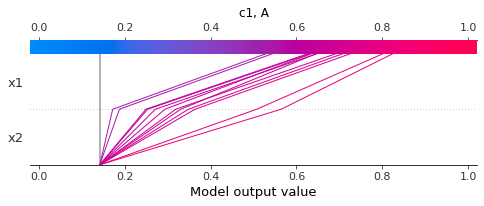

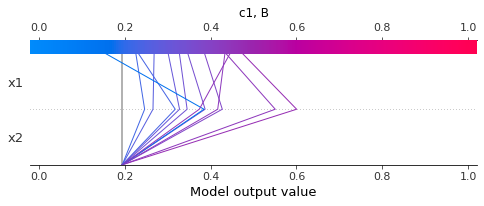

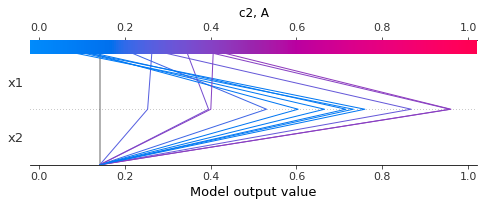

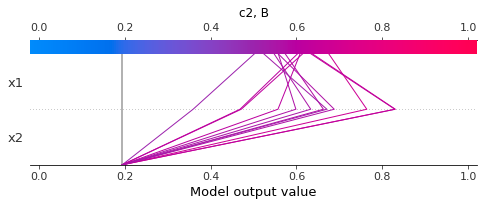

In [69]:
indiv = explanations_clustered.indiv.log_odds[:, :, 1]
for cluster_name in indiv.A.cohorts.keys():
    for clf_name, shap_values in [('A', indiv.A), ('B', indiv.B)]:
        shap_values = shap_values.cohorts[cluster_name]
        shap.decision_plot(shap_values.base_values[0], shap_values.values, features=shap_values.data,
                           feature_names=shap_values.feature_names, feature_order=feature_order,
                           link='logit', title=f'{cluster_name}, {clf_name}')

### Force Plot

Furthermore we visualize the instances in force plots, ordered by similarity of their multiclass difference classes.

In [68]:
indiv = explanations_clustered.indiv.log_odds[:, :, 1]
for cluster_name in indiv.A.cohorts.keys():
    instance_order = calc_instance_order(
        explanations_clustered.mclass_diff.log_odds[
            :,
            :,
            comparer.difference_class_names
        ].cohorts[cluster_name])
    for clf_name, shap_values in [('A', indiv.A), ('B', indiv.B)]:
        shap_values = shap_values.cohorts[cluster_name]
        plot = shap.plots.force(
            base_value=shap_values.base_values[0],
            shap_values=shap_values.values,
            features=shap_values.data,
            feature_names=shap_values.feature_names,
            out_names=f'{cluster_name}, {clf_name}',
            ordering_keys=instance_order.tolist(),
            link='logit')
        display(plot)